In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy
frame = cv2.imread('Black+white puck.jpg')

# Puck detection
The purpous of this algoritm is to try and detect all the pucks in the qvga (320x240) size pictures from the ESP cam. 
The following 3 different general algoritms where explored for efficiancy.

### HoughCircles on thresholded image


Text(0.5, 1.0, 'Thresholded')

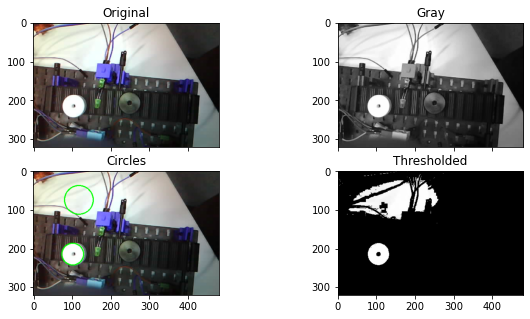

In [3]:

# Create a 2x2 subplots to show the different stages of the detection
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True)

# We are edititing the original image so we make a copy to not impact the other images
img = frame.copy()
ax[0][0].imshow(img) # Show the original image on the first subplot

# Blur the image to reduce noise mainly from lossy compression
blur = cv2.medianBlur(img, 5)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to make it black and white, this is needed 
# because the HoughCircles function only detects circles when the outline of 
# the circle is one colour. It is not one color because of the inhernt noise 
# in the image and because the lighting might be direction
# We would need two thresholds for the white and the black pucks and they 
# would need to be fine tuned for each senario
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
result = cv2.bitwise_and(gray, gray, mask=mask)

# Detect the circles using the HoughCircles funciton
# the param1 and param2 values are the most important to tune
# param1 is the higher threshold for the canny edge detector
# param2 is the accumulator threshold for the circle center at the detection stage
circles = cv2.HoughCircles(result, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Draw the circles on the image
if circles is not None:
    circles = numpy.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        True
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)

# Show the images on the subplots
ax[1][0].imshow(img)
ax[1][1].imshow(result, cmap='gray')
ax[0][1].imshow(gray, cmap='gray')

ax[0][0].set_title('Original')
ax[0][1].set_title('Gray')
ax[1][0].set_title('Circles')
ax[1][1].set_title('Thresholded')

This algoritm has several downsides the most important one is that it is very dependend on lighting conditions, espcicially for the black pucks. This is because difference between the belt and the puck is subtile and havily impacted by lighting conditions. 
It also has the tendancy to detect circles in the lighting "belts" from the limited color spectrum of the ESP-cam's JPEG compression. This is the circle seen in the y=100 x=100 area.


### Outlines, area and length
Another algoritm suggested by people on the stackoverflow by the user Nathancy (https://stackoverflow.com/a/60644656), was instead of detecting circles is to detect all outlines and are possibly a circle by looking at the length of the outline and total area. 


Text(0.5, 1.0, 'Contours')

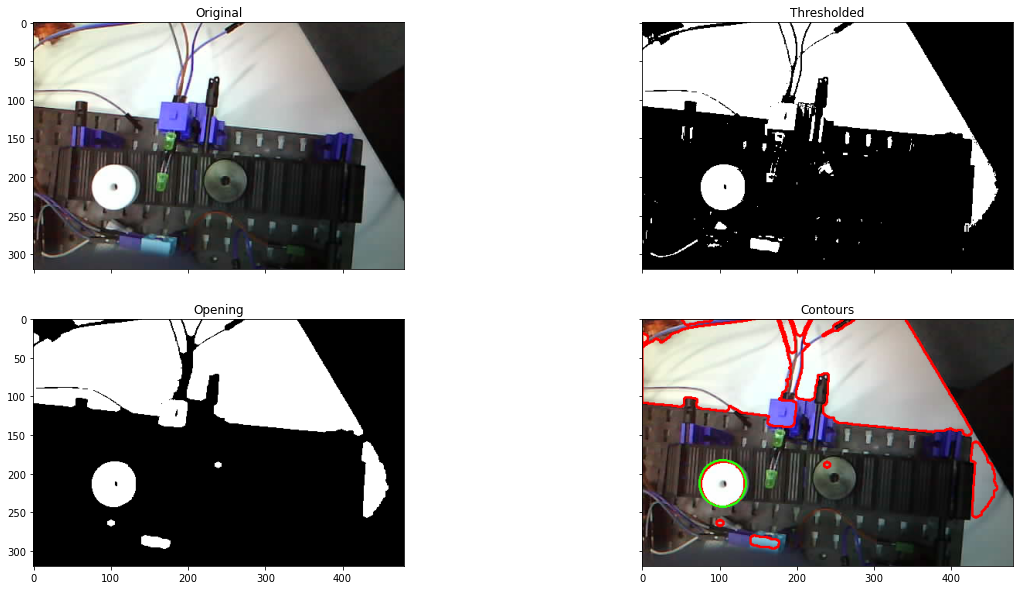

In [4]:
# Create a 2x2 subplot figure
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)

# Create a copy of the frame to not impact the original
img = frame.copy()

# Display the original image
ax[0][0].imshow(img)
ax[0][0].set_title('Original')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur the image to reduce noise mainly from lossy compression
blur = cv2.medianBlur(gray, 1)

# Threshold the image to make it black and white, so we can get the outlines
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)[1]

# Display the grayscale and thresholded images
ax[0][1].imshow(thresh, cmap='gray')
ax[0][1].set_title('Thresholded')

# Try and make the circles more complete by using morphological operations 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
ax[1][0].imshow(opening, cmap='gray')
ax[1][0].set_title('Opening')

# Find contours and filter using contour area and aspect ratio
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.drawContours(img, cnts, -1, (255, 0, 0), 2)
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    area = cv2.contourArea(c)
    if len(approx) > 5 and area > 1000 and area < 3000:
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(img, (int(x), int(y)), int(r), (36, 255, 12), 2)

ax[1][1].imshow(img)
ax[1][1].set_title('Contours')


As seen this algoritm still relies on thresholding which makes the detection of black pucks challanging with different lighting. However the detection of circles is more trivial than the previous algoritm.

## Hough circles on canny edges

The idea of this algoritm is to run the hough circles like the first algoritm, however instead of running the circle detection on a threshold map (which can be fidally for black on black) we run it on a canny edges image. This is an algoritm to detect all the edges in image. Then on all these edges run the algoritm to find the circles.

The 4 parameters that impract the results are param1, param2, minRadius and maxRadius of the HoughCircles. These parameters have to tuned for how our pucks look on the camera. However because we first do the canny edge detection, this is not impacted by the lighting conditions.

Text(0.5, 1.0, 'Detected Circles')

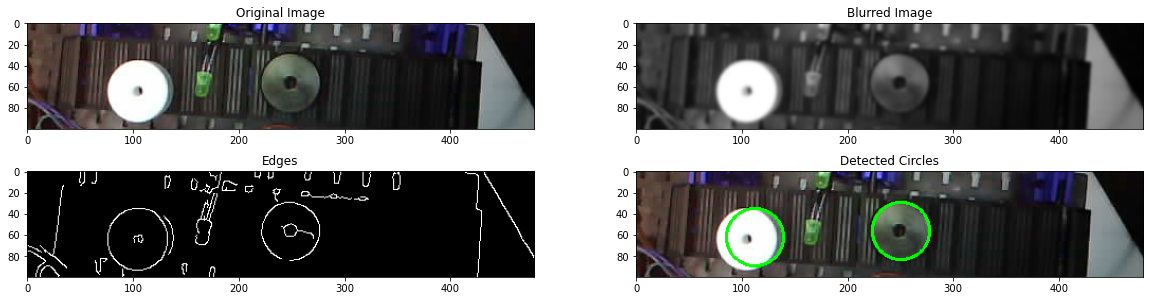

In [9]:
img = frame.copy()

# Crop the image to focus on the puck
img = img[150:250, 0:500]

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax[0][0].imshow(img)
ax[0][0].set_title('Original Image')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (7, 7), 0)

# Display the blurred image
ax[0][1].imshow(blur, cmap='gray')
ax[0][1].set_title('Blurred Image')

# Detect edges using Canny edge detection
edges = cv2.Canny(blur, 50, 150)

# Display the edges
ax[1][0].imshow(edges, cmap='gray')
ax[1][0].set_title('Edges')

# Detect circles using Hough circle detection
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=50)

# Draw detected circles on the original image
if circles is not None:
    circles = numpy.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)

# Display the image with detected circles
ax[1][1].imshow(img)
ax[1][1].set_title('Detected Circles')

This the algoritm we are using in the actual machine because of its versitility.

## Arduino connection

In order to get information from the phototransistors and activate the servos and the stepper, the raspberry pie is connected with 2 arduinos via serial. We are using a Node MCU in order to control everything that has to do with the arm (a servo and 2 phototransistors) that is pushing the disks from the factory floor and an Arduino Uno in order to control everything that is happening on our belt (3 servos, one stepper and one phototransistor). We are establishing the connection by using the serial python import and connecting the Arduinos via USB to the raspberry pie. We are also using logging in order to make debugging easier.

In [ ]:
import serial
import numpy as np
import logging
from time import perf_counter, sleep

# Logging for debugging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(name)s %(message)s')
# Connecting the Arudinos

BlackWhiteArduino = serial.Serial(
    'COM5', 9600)
FactoryPushArduino = serial.Serial('COM6', 9600)
#timeout in case Arduinos don't respond
BlackWhiteArduino.timeout = 0.1
FactoryPushArduino.timeout = 0.1



In order to control the Servos, we are sending messages and encoding them to move the servo a certain angle. We are also doing the same thing with the stepper. For the phototransistors, we are constantly getting information from the Arduinos by reading and then decoding the information. At the beginning of the code, we ensure that all of the servos are in their correct position. We are also using timers in order to control for how much time the disks are able to stay on our belt, as well as to ensure that after a disk has fallen into it's respective bin, the servos go to their default position in order to let the other disks pass on the conveyor belt. We are also using a servo for the catapult in order to launch it. The servo is activated after a certain amount of time after the stepper has been given the position where it needs to go for it to arm the catapult. The catapult is armed when the phototransistor for the catapult changes it's value drastically. All of these are connected to the BlackWhiteArduino. 
When it comes to the arm that is pushing the disks, it is controlled by a servo which is activated when the value of the 2 phototransistors directed to the factory floor changes. All of this is controlled by the FactoryPushArduino.

In [ ]:

#declaring timers
timers = []

#declare the can_detect variable
can_detect = 1

# Create phototransistors data
lightSens1Data = 0
lightSens2Data = 0
lightSens3Data = 0

# Is the current photo transistor value copied over from the default?
lightSens1WasTaken = False
lightSens2WasTaken = False
lightSens3WasTaken = False

lightSens1TriggerTime = 0

#declaring the servo angles
whiteAngleDefault = 100
whiteAnglePush = 145

blackAngleDefault = 0
blackAnglePush = 45

#Send Black servo to default value
BlackWhiteArduino.write(f"B{blackAngleDefault}".encode())
#Send White servo to default value
BlackWhiteArduino.write(f"W{whiteAngleDefault}".encode())


while True:
    # Get the current time
    currentTime = perf_counter()
    # Get the data from the factory push Arduino
    factoryData = FactoryPushArduino.readline().decode().strip()
    FactoryPushArduino.flushInput()
    # Check if there's something in factoryData
    if factoryData is not None:
        # Get the parts from factoryData
        parts = factoryData.split()  
        # Now we check for what kind of data is in factoryData
        # Check if there is the value of the phototransistor
        if parts is not None and "R" not in parts[0]:
            # if so, then put the value in lightSens
            #lightSens1 = parseLightSensorData(factoryData)
            
            if lightSens1WasTaken == False:
                defaultLightSens1 = int(parts[0])
                lightSens1WasTaken = True
            
            elif abs(lightSens1Data-defaultLightSens1) > 100:
                lightSens1TriggerTime = currentTime
                
                # if so, then put the value in lightSens
            #lightSens2 = parseLightSensorData(factoryData)
            
            if lightSens2WasTaken == False:
                try:
                    defaultLightSens2 = parts[1]
                    lightSens2WasTaken = True
                except: True
            
            elif abs(lightSens2Data-defaultLightSens2) > 100:
                if abs(lightSens1TriggerTime-currentTime) < 0.5:
                    # we set the angle for the servo
                    angleFactory = 20
                    # message to tell to Arduino:
                    message = f"P {angleFactory}\n"
                    # write the message to Arduino
                    FactoryPushArduino.write(message)
                    # put the timer into the timers array
                    timers.append([0, currentTime+1, "P 0\n"])
    if(can_detect == 1):
        a = detected_circle(esp_cam_1)
        if not a == "NONE":
            circleColor = a
            print ("Not black or white circle detected")
        else: circleColor = "No circle or circle that is not black or white detected"
    

    #Check the color of the detected circle
    if (circleColor == 'WHITE'):
        #Can no longer detect circles
        can_detect = 0
        #Print the detected circle
        print("White circle detected")
        #Make the White servo move
        print("Move White servo to pushing position")
        BlackWhiteArduino.write(f"W {whiteAnglePush}\n".encode())
        #Tell the white servo to move to default after 9 seconds
        timers.append([1, currentTime+15, f"W {whiteAngleDefault}\n"])
        #update the white position
        WhitePosition = 1
        # sleep to wait for the servo to move
        sleep(0.5)

    elif (circleColor == "BLACK"):
        can_detect = 0
        print("Black Circle detected")
        print("Move Black servo to pushing position")
        BlackWhiteArduino.write(f"B {blackAnglePush}\n".encode())
        timers.append([1, currentTime+22, f"B {blackAngleDefault}\n"])
        #update the black position
        BlackPosition = 1
        # sleep to wait for the servo to move
        sleep(0.5)
    
    #Check the catapult phototransistor value
     # Set the reference photoresolution for the catapult, if it hasn't been set yet
    if (lightSens3WasTaken == False):
        print("Setting the reference photoresolution for the catapult")
        lightSens3WasTaken = True
        defaultLightSens1 = lightSens3Data
    elif abs(lightSens3Data-defaultLightSens3) > 200:
        print("Starting catapult")
        BlackWhiteArduino.write("R 180 \n".encode())
        BlackWhiteArduino.write(f"S {catapultServoPosition} \n".encode())
        timers.append([1, currentTime+10.2, f"S 0\n"])
        timers.append([1, currentTime+9.2, "R 90\n"])

    # Check the timers
    for index, timer in enumerate(timers):
        # if the current time is higher than the timer
        if (currentTime > float(timer[1])):
            # check for which arduino it is
            # if the timer is for the Factory arduino
            if(timer[0]==0):
                #Print in the Arduino the default angle for the servo
                FactoryPushArduino.write(timer[2].encode())
                timers.pop(index)
            # else if the timer is for the BlackWhite arduino, then print and pop what is in timer
            if (timer[0] == 1):
                if 'W' in timer[2]:
                    print("Moveing White servo to default position")
                    BlackWhiteArduino.write(timer[2].encode())
                    timers.pop(index)
                    can_detect=1
                    # say that you have processed a disk
                    # client.publish(f"robots/progress/group22", 1, qos=1)
                    WhitePosition = 0
                    #sleep in order for the servo to get back in position
                    sleep(0.5)
                elif 'B' in timer[2]:
                    print("Moveing Black servo to default position")
                    BlackWhiteArduino.write(timer[2].encode())
                    timers.pop(index)
                    can_detect=1
                    # say that you hav  e processed a disk
                    # client.publish(f"robots/progress/group22", 1, qos=1)
                    BlackPosition = 0
                    #sleep in order for the servo to get back in position
                    sleep(0.5)
                elif 'S' in timer[2]:
                    print("Moveing catapult servo to default position")
                    BlackWhiteArduino.write(timer[2].encode())
                    timers.pop(index)
                    can_detect=1
                    haveDetectedCatapult = False
                elif 'R' in timer[2]:
                    print("Launching the catapult")
                    BlackWhiteArduino.write(timer[2].encode())
                    timers.pop(index)
                    can_detect=1

## Error detection

In order to do error detection, we are using the camera, as well as the maximum and minimum values of the phototransistors.

One type of error detection that we are using is checking if the phototransistors have real, achievable, values. If they don't then, there must be something wrong with them and we are giving an error.

Another type of error detection that we are doing is verifying if the servos are in their correct place by checking the color of a pixel in each state. The color of the pixel is gotten at the start of the code in order to make sure that it fits any lighting conditions. The colors are gotten for both the default and when_moved positions.

One other type of error detection is checking if the cameras are working by checking if the color of a certain pixel that cannot be chnaged is near a certain value. If it is not, then the camera is not working and we are switching the cameras. If none of the cameras are not working, then we are giving an error.


In [ ]:
#declare constants for the color checker
colorCheckerX1 = 1559
colorCheckerY1 = 252
targetcolor1 = np.array([131, 70, 85])
colorCheckerX2 = 183
colorCheckerY2 = 856
targetcolor2 = np.array([120, 60, 85])

workingCamera1 = True
workingCamera2 = True

def compare_pixel_colors(default_value, color):
    # Calculate the Euclidean distance between two colors
    def color_distance(color1, color2):
        r1, g1, b1 = color1
        r2, g2, b2 = color2
        return np.sqrt((r2 - r1)**2 + (g2 - g1)**2 + (b2 - b1)**2)

    # Calculate the color distance
    distance = color_distance(color, default_value)

    # Define a threshold to determine the proximity
    threshold = 50

    # Check if the color distance is within the threshold
    result = 1 if distance < threshold else 0

    return result

def check_pixel_color(image, x, y, target_color, tolerance=10):
    # Extract the color of the specified pixel
    pixel_color = image[y, x, :]
    
    # Calculate the difference between the pixel color and the target color
    color_diff = np.abs(pixel_color - target_color)
    
    # Check if the color difference is within the specified tolerance
    if np.all(color_diff <= tolerance):
        return True
    else:
        return False
def getDefaultBumperColor(image):
    val1 = image[623,570]
    val2 = image[637, 1000]
    return (val1, val2)
#get the default rgb values for the bumpers when moved
def getWhenMovedColor(image):
    val1 = image[657,697]
    val2 = image[687, 1007]
    return (val1, val2)


print("Getting the servos to default position")

#Put the servos in their default place
BlackWhiteArduino.write(f"B {blackAngleDefault}\n".encode())
sleep(0.01)
BlackWhiteArduino.write(f"W {whiteAngleDefault}\n".encode())

#Check the color of the bumpers in the lighting condition on the site
cap = cv2.VideoCapture(1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
currentTime = perf_counter()
_,image = cap.read()
while image is None and perf_counter() - currentTime < 60:
    _,image = cap.read()
    cv2.waitKey(1)
if(image is None):
    cap.release()
    print("Camera 1 not working")
    cap = cv2.VideoCapture(2)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    _,image = cap.read()
    print("Checking connection to camera 2")
    
currentTime = perf_counter()
while image is None and perf_counter() - currentTime < 60:
    _,image = cap.read()
    cv2.waitKey(1)
if(image is None):
    
    print("None of the cameras are working :( ")
    
if(not check_pixel_color(image, colorCheckerX1, colorCheckerY1, targetcolor1)):
    if(workingCamera1 == True):
        workingCamera1 = False
        print("Camera 1 not working")
        print("Checking connection to camera 2")
        cap = cv2.VideoCapture(2)
        _, image = cap.read()
        currentTime = perf_counter()
        while image is None and perf_counter() - currentTime < 60:
            _,image = cap.read()
        if(image is None):
            
            print("None of the cameras are working :( ")
            
if(not check_pixel_color(image, colorCheckerX2, colorCheckerY2, targetcolor1) and workingCamera1 == False):
    print("None of the cameras are working :( ")

#getting the default color of the bumpers for the lighting condition on the site
print("Getting the default color of the bumpers")
defaultWhiteColor , defaultBlackColor = getDefaultBumperColor(image)


whenMovedWhiteColor , whenMovedBlackColor = getWhenMovedColor(image)
#Getting the when moved color of the bumpers for the lighting condition on the site
print("Getting the when moved color of the bumpers")
BlackWhiteArduino.write(f"B {blackAngleDefault}\n".encode())
sleep(0.01)
BlackWhiteArduino.write(f"W {whiteAngleDefault}\n".encode())
sleep(0.5)
#Declare in which state the 2 bumpers should be

BlackPosition = 0
WhitePosition = 0

while True:
    _, image = cap.read()
    if(workingCamera1 == True):
        if(not check_pixel_color(image, colorCheckerX1, colorCheckerY1, targetcolor1)):
            
            print("Camera 1 not working")
            workingCamera1 = False
            print("Checking connection to camera 2")
            cap = cv2.VideoCapture(2)
            _, image - cap.read()
            currentTime = perf_counter()
            while image is None and perf_counter() - currentTime < 60:
                _,image = cap.read()
            if(image is None):
                print("None of the cameras are working :( ")
            else: 
                if(not check_pixel_color(image, colorCheckerX2, colorCheckerY2, targetcolor2)):
                    print("None of the cameras are working :( ")
    if(workingCamera2 == True):
        _,image = cap.read()
        if(not check_pixel_color(image, colorCheckerX2, colorCheckerY2 ,targetcolor2)):
            print("None of the cameras are working :( ")
    if(image is not None):
        print("Checking if the bumpers are in the correct position")
        if(BlackPosition == 0):
            color = image[637, 1000]
            if(not compare_pixel_colors(defaultBlackColor, color)):
                #send error message
                print("ERROR: Black bumper not in correct position")

        elif(BlackPosition == 1):
            color = image[687, 1007]
            if(not compare_pixel_colors(whenMovedBlackColor, color)):
                #send error message
                print("ERROR: Black bumper not in correct position")
        if(WhitePosition == 0):
            color = image[623,570]
            if(not compare_pixel_colors(defaultWhiteColor, color)):
                #send error message
                print("ERROR: White bumper not in correct position")
        
        elif(WhitePosition == 1):
            color = image[657,697]
            if(not compare_pixel_colors(whenMovedWhiteColor, color)):
                #send error message
                print("ERROR: White bumper not in correct position")

The main robot logic is a combination of everything above, putting everything together in one place, as well as with the camera.py program that is doing the circle detection as explained at the start of the notebook.